# Section 01. 결측치 처리
## 1. 결측치 개념

이번 절에서는 데이터 분석 맛보기로, 주어진 데이터를 이용해 생존율을 분석해보는 연습을 한다. 연령별, 성별, 보트 탑승객, 귀족 계급별 생존율을 살펴본다.
먼저 타이타닉 데이터를 가져온다. 이때 분석에 사용하지 않을 body, home.dest 열은 삭제한다.

In [3]:
import pandas as pd

titanic_url = 'https://github.com/sehakflower/data/blob/main/titanic_1309.xlsx?raw=true'

titanic = pd.read_excel(titanic_url, sheet_name = 'total')
titanic_df = titanic.drop(['body', 'home.dest'], axis = 1)
titanic_df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN


## 연령별 생존율 파악하기
연령별로 생존율이 어떠한지 파악해보자. cut 함수는 열의 값을 특정 기준을 나눌 때 사용한다. bins 옵션으로 나누는 구간을 정할 수 있으며 labels 옵션으로 구간별 라벨을 설정할 ㅅ ㅜ있다. 구간으로 나눈 값을 'age_cat'이라는 새로운 열에 대입한다.

In [4]:
titanic_df['age_cat'] = pd.cut(titanic_df['age'],
                               bins = [0, 3, 7, 15, 30, 60, 100],
                               include_lowest = True,
                               labels = ['baby', 'children', 'teenage', 'young', 'adult', 'old'])

titanic_df.groupby('age_cat', observed = True).mean(numeric_only = True)                               

,pclass,survived,age,sibsp,parch,fare
age_cat,,,,,,
baby,2.585366,0.634146,1.540651,1.487805,1.365854,29.615346
children,2.640000,0.640000,5.160000,1.760000,1.360000,31.022828
teenage,2.632653,0.489796,11.540816,1.734694,1.163265,38.390904
young,2.412955,0.368421,23.389676,0.352227,0.236842,27.313140
adult,1.893564,0.423267,41.548267,0.376238,0.405941,47.141986
old,1.545455,0.242424,65.393939,0.303030,0.363636,60.248309


결과를 보면 baby와 children의 생존율이 높다. 생존율을 승객 등급(pclass), 연령(age_cat), 성별(sex)에 따라 간단히 시각화하는 방법을 알아보자.

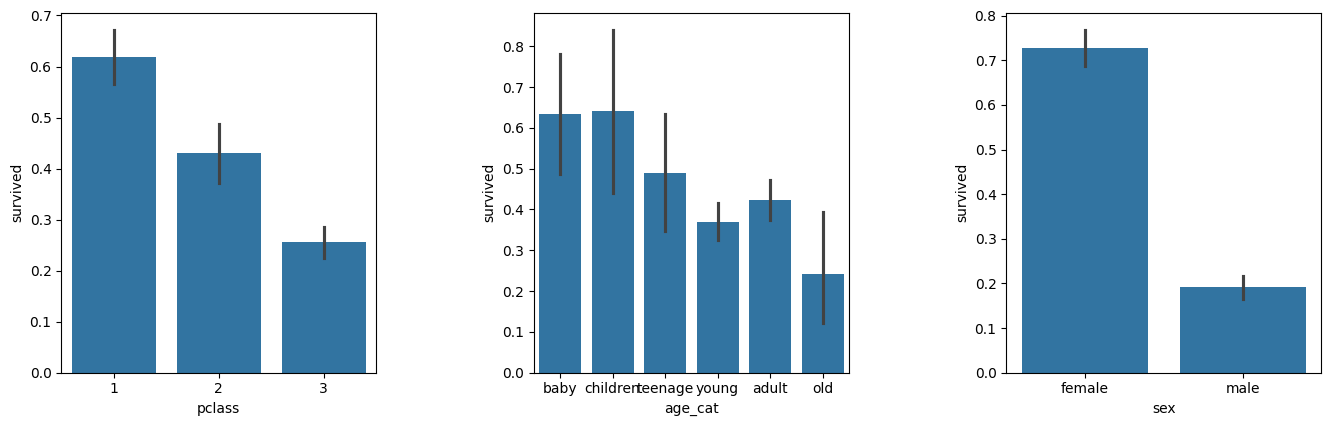

In [5]:
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

data = titanic_df
plt.figure(figsize = [14, 4])
plt.subplot(131)
sns.barplot(x = 'pclass', y = 'survived', data = titanic_df)

plt.subplot(132)
sns.barplot(x = 'age_cat', y = 'survived', data = titanic_df)

plt.subplot(133)
sns.barplot(x = 'sex', y = 'survived', data = titanic_df)

plt.subplots_adjust(top = 1, bottom = 0.1, left = 0.1, right = 1, hspace = 0.5, wspace = 0.5)
plt.show()

In [7]:
titanic_df.groupby(['pclass', 'sex']).mean(numeric_only = True)

survived        age     sibsp     parch        fare
pclass sex                                                        
1      female  0.965278  37.037594  0.555556  0.472222  109.412385
       male    0.340782  41.029250  0.340782  0.279330   69.888385
2      female  0.886792  27.499191  0.500000  0.650943   23.234827
       male    0.146199  30.815401  0.327485  0.192982   19.904946
3      female  0.490741  22.185307  0.791667  0.731481   15.324250
       male    0.152130  25.962273  0.470588  0.255578   12.415462

1등급 승객 중 여성의 생존율이 높다. 3등급 여성의 생존율의 1\~2등급에 비해 낮고 남성은 2~3등급 간 차이가 없다.

## 보트 탑승 승객의 생존율 파악하기
보트 탑승 승객의 생존율을 파악해보자. 보트에 탑승한 승객만 추려서 boat_survivors 데이터프레임에 저장하고 탑승하지 못한 승객은 nboat_survivors에 저장한 뒤 성별 생존율을 비교해보자.

In [10]:
boat_survivors = titanic_df[titanic_df['boat'].notnull()]
nboat_survivors = titanic_df[titanic_df['boat'].isnull()]

print(boat_survivors.groupby('sex')['survived'].mean())
print(nboat_survivors.groupby('sex')['survived'].mean())

sex
female    0.996865
male      0.952096
Name: survived, dtype: float64
sex
female    0.142857
male      0.002959
Name: survived, dtype: float64


비교 결과를 보면, 보트에 탑승하지 못한 승객의 생존율이 매우 낮으며 특히 남성의 생존율이 극히 낮다. 이를 그림으로 시각화한 결과를 보면 전반적으로 보트에 탔던 승객은 거의 생존했던 것을 확인할 수 있다.

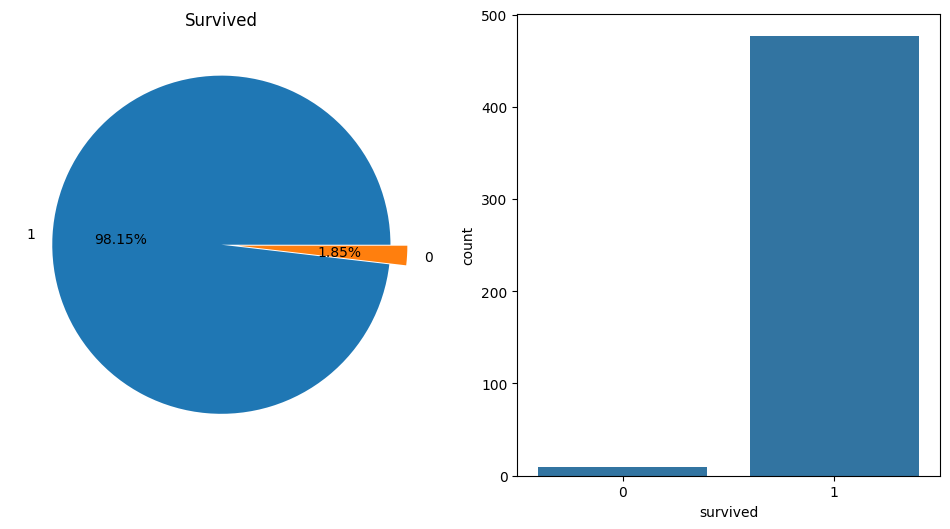

In [12]:
f, ax = plt.subplots(1, 2, figsize = (12, 6))
boat_survivors['survived'].value_counts().plot.pie(explode = [0, 0.1],
                                                   autopct = '%1.2f%%',
                                                   ax = ax[0])
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x = 'survived', data = boat_survivors, ax = ax[1])
plt.show()

## 귀족 계급의 생존율 파악하기
이번에는 귀족 계급의 생존율을 파악해본다. name 열의 호칭을 이용해 귀족 계급과 그렇지 않은 계급 간의 생존율을 비교한다.

In [14]:
conversion_special = lambda x: x.split(',')[1].split('.')[0].strip()
titanic_df['title'] = titanic_df['name'].map(conversion_special)
titanic_df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,age_cat,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,young,Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,baby,Master
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,baby,Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,young,Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,young,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,teenage,Miss
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,Miss
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,young,Mr
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,young,Mr
